In [645]:
!pip install face_recognition
!pip install opencv-python-headless

In [646]:
import os
from google.colab import drive
import face_recognition
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import pandas as pd
import matplotlib.pyplot as plt

In [647]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [648]:
unlabelled_folder = '/content/drive/MyDrive/unlabeled_library_images/' #this is the folder where images originally are before labeling
labelled_folder = '/content/drive/MyDrive/labelled_library_images/' #the images are moved here
spreadsheet_folder = '/content/drive/MyDrive/unlabeled_library_images/' #any database files go here

#note you can edit and put whatever folders you want those are just the name of my folders^

In [649]:
unlabelled_images = os.listdir(unlabelled_folder)
print(unlabelled_images)

['dwayne.jpg', '.ipynb_checkpoints', 'faces_data.csv', 'image_face_names.csv', 'new_data.csv', 'test.csv']


In [650]:
if os.path.exists(spreadsheet_folder + 'faces_data.csv'):
    faces_data = pd.read_csv(spreadsheet_folder + 'faces_data.csv')[['name','face_encoding']]#data of faces and encodings
else:
    faces_data = pd.DataFrame(columns = ['name','face_encoding'])
if os.path.exists(spreadsheet_folder + 'image_face_names.csv'):
    image_face_names = pd.read_csv(spreadsheet_folder + 'image_face_names.csv') #images and the existing names in those images
else:
    image_face_names = pd.DataFrame(columns = ['image_name','face_names'])
if os.path.exists(spreadsheet_folder + 'new_data.csv'):
    new_data = pd.read_csv(spreadsheet_folder + 'new_data.csv') #this is where the new labeling data is put
else:
    new_data = pd.DataFrame(columns = ['image_name','faces'])

In [651]:
faces_data.head(11)

,name,face_encoding
0,Ashkar,"[-0.18324539065361023, 0.1227283924818039, 0.0..."
1,ikram,"[-0.08382032066583633, 0.08915513753890991, -0..."
2,khalil,"[-0.19419795274734497, 0.06705864518880844, 0...."
3,isamil,"[-0.14713019132614136, 0.05713728070259094, -0..."
4,Ebram,"[-0.07837033271789551, 0.04806605353951454, -0..."
5,Suarez,"[-0.20483390986919403, 0.13607002794742584, 0...."
6,NEMO,"[-0.05894104763865471, 0.18076062202453613, 0...."
7,Wres,"[-0.14568693935871124, 0.10534437000751495, 0...."
8,Dwayne,"[-0.14001800119876862, 0.19072787463665009, 0...."
9,Tom,"[-0.16988705098628998, 0.11156287044286728, 0...."


In [652]:
image_face_names.head()

,image_name,face_names
0,WhatsApp Image 2024-05-30 at 10.18.47_97793ef2...,Ebram
1,WhatsApp Image 2024-07-17 at 18.59.31_81e74e82...,Ebram
2,321670358_1379018396174306_8323900925920846555...,Ebram
3,tom.jpg,Tom
4,dwayne.jpg,Dwayne


In [653]:
new_data.head()

,image_name,faces
0,dwayne.jpg,[Dwayne]


In [654]:
faces_data['face_encoding'] = faces_data['face_encoding'].apply(lambda enc: np.array(eval(enc)))
new_data['faces'] = new_data['faces'].apply(lambda x: eval(x.replace('[', '["').replace(']', '"]').replace(',', '","')))



In [655]:
def find_closest_encoding(df, encoding):
  all_encodings = np.array(df['face_encoding'].tolist())
  distances = face_recognition.face_distance(all_encodings, encoding)
  best_match_index = np.argmin(distances)
  if distances[best_match_index] <= 0.70:
    matched_name = df.iloc[best_match_index]['name']
  else:
    matched_name = 'UNKOWNINSTANCE'
  print(matched_name)
  return best_match_index, matched_name

In [656]:
def label_using_csv():
  for image in unlabelled_images:
    if not 'jpg' in image:
      continue
    try:
      image_dir = unlabelled_folder+image
      pairs = {}
      faces_unparsed = new_data.loc[new_data['image_name'] == image, 'faces'].iloc[0]
      try:
        faces_in_curr = eval(faces_unparsed.replace('[', '["').replace(']', '"]').replace(',', '","'))
      except:
        faces_in_curr = faces_unparsed
      loaded_image = face_recognition.load_image_file(image_dir)
      face_locations = face_recognition.face_locations(loaded_image)
      face_encodings = face_recognition.face_encodings(loaded_image, face_locations)


      face_encodings_sorted = [encoding for _, encoding in sorted(zip(face_locations, face_encodings), key=lambda x: x[0][3])]
      for i,face_encoding in enumerate(face_encodings_sorted):
        if len(faces_data[faces_data['name'] == faces_in_curr[i]]) > 0:
          row_ind, name = find_closest_encoding(faces_data,face_encoding)
          if not name == faces_in_curr[i]:
            old_facial_enc = faces_data.loc[faces_data['name'] == faces_in_curr[i],'faces'].iloc[0]
            if old_facial_enc.ndim == 1:
              old_facial_enc = [old_facial_enc]
            faces_data.loc[faces_data['name'] == faces_in_curr[i],'faces'].iloc[0] = np.append(old_facial_enc, face_encoding.tolist()) #**
        else:
          faces_data.loc[len(faces_data)] = [faces_in_curr[i], face_encoding.tolist()]
        pairs[str(face_encoding.tolist())] = faces_in_curr[i]

      names_corrected = []

      for face_encoding in face_encodings:
        names_corrected.append(pairs[str(face_encoding.tolist())])

      image_face_names.loc[len(image_face_names)] = [image,names_corrected]
    except Exception as e: #using this to catch non-images
      print(e)





In [657]:
def cascade_on_uploaded_images():
  for image in unlabelled_images:
    try:
      image_dir = unlabelled_folder+image

      loaded_image = face_recognition.load_image_file(image_dir)
      face_locations = face_recognition.face_locations(loaded_image)
      face_encodings = face_recognition.face_encodings(loaded_image, face_locations)
      names_corrected = []
      for i,face_encoding in enumerate(face_encodings):
        row_ind, name = find_closest_encoding(faces_data,face_encoding)
        if matched_name != 'UNKOWNINSTANCE':
          names_corrected.append(matched_name)
        else:
          #label as unkown if thats implemented
          pass
      image_face_names.loc[len(image_face_names)] = [image,names_corrected]
    except Exception as e: #using this to catch non-images
      print(e)

In [658]:
def draw_labels_on_image(image, face_locations, names):
    image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    for (top, right, bottom, left), name in zip(face_locations, names):
        cv2.rectangle(image_bgr, (left, top), (right, bottom), (0, 255, 0), 2)
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(image_bgr, name, (left, bottom + 20), font, 0.5, (0, 255, 0), 2)
    return image_bgr

In [659]:
def print_labelled_images():
  for image in unlabelled_images:
    try:
      image_dir = unlabelled_folder+image

      loaded_image = face_recognition.load_image_file(image_dir)
      face_locations = face_recognition.face_locations(loaded_image)
      face_encodings = face_recognition.face_encodings(loaded_image, face_locations)
      names = []
      for i,face_encoding in enumerate(face_encodings):
        row_ind, name = find_closest_encoding(faces_data,face_encoding)
        names.append(name)
      image_with_labels = draw_labels_on_image(loaded_image, face_locations, names)
      cv2_imshow(image_with_labels)
      cv2.waitKey(0)
      cv2.destroyAllWindows()
    except Exception as e: #using this to catch non-images
      print(e)

newdata structure:
image_name, faces (from left to right)

Pseudocode for later (initial labeling):
```
for all_images:
  run face_recognition();
  for all_faces:
    if !smallest.face.distance == csv_face_name:
       add_encoding_to_faces_data();
    if new_face:
       add_row_to_faces_data();
    add_row_to_image_face_names(); //needs to follow face_encodings placement not the new_csv files placement
```

Cascade code

```
for all_images:
  run face_recognition();
  for all_faces:
    if face.passes_threshold:
       add_encoding_to_faces_data(face.get_smallest_distance());
    else:
       label_as_unkown(); #might just be do nothing in this case
    add_row_to_image_face_names();
```


print images code

```
for all_images:
  run face_recognition();
  for all_faces:
    if face.passes_threshold:
       label_face(face.get_smallest_distance());
    else:
       label_as_unkown(); #might just be do nothing in this case
    print_using_opencv();
```




In [660]:
label_using_csv()

Dwayne


In [661]:
faces_data.to_csv(spreadsheet_folder + 'test.csv', index = False)
#image_face_names.to_csv(spreadsheet_folder + 'image_face_names.csv', index = False)

In [662]:
#print_labelled_images()
faces_data.head(20)

,name,face_encoding
0,Ashkar,"[-0.18324539065361023, 0.1227283924818039, 0.0..."
1,ikram,"[-0.08382032066583633, 0.08915513753890991, -0..."
2,khalil,"[-0.19419795274734497, 0.06705864518880844, 0...."
3,isamil,"[-0.14713019132614136, 0.05713728070259094, -0..."
4,Ebram,"[-0.07837033271789551, 0.04806605353951454, -0..."
5,Suarez,"[-0.20483390986919403, 0.13607002794742584, 0...."
6,NEMO,"[-0.05894104763865471, 0.18076062202453613, 0...."
7,Wres,"[-0.14568693935871124, 0.10534437000751495, 0...."
8,Dwayne,"[-0.14001800119876862, 0.19072787463665009, 0...."
9,Tom,"[-0.16988705098628998, 0.11156287044286728, 0...."


Dwayne


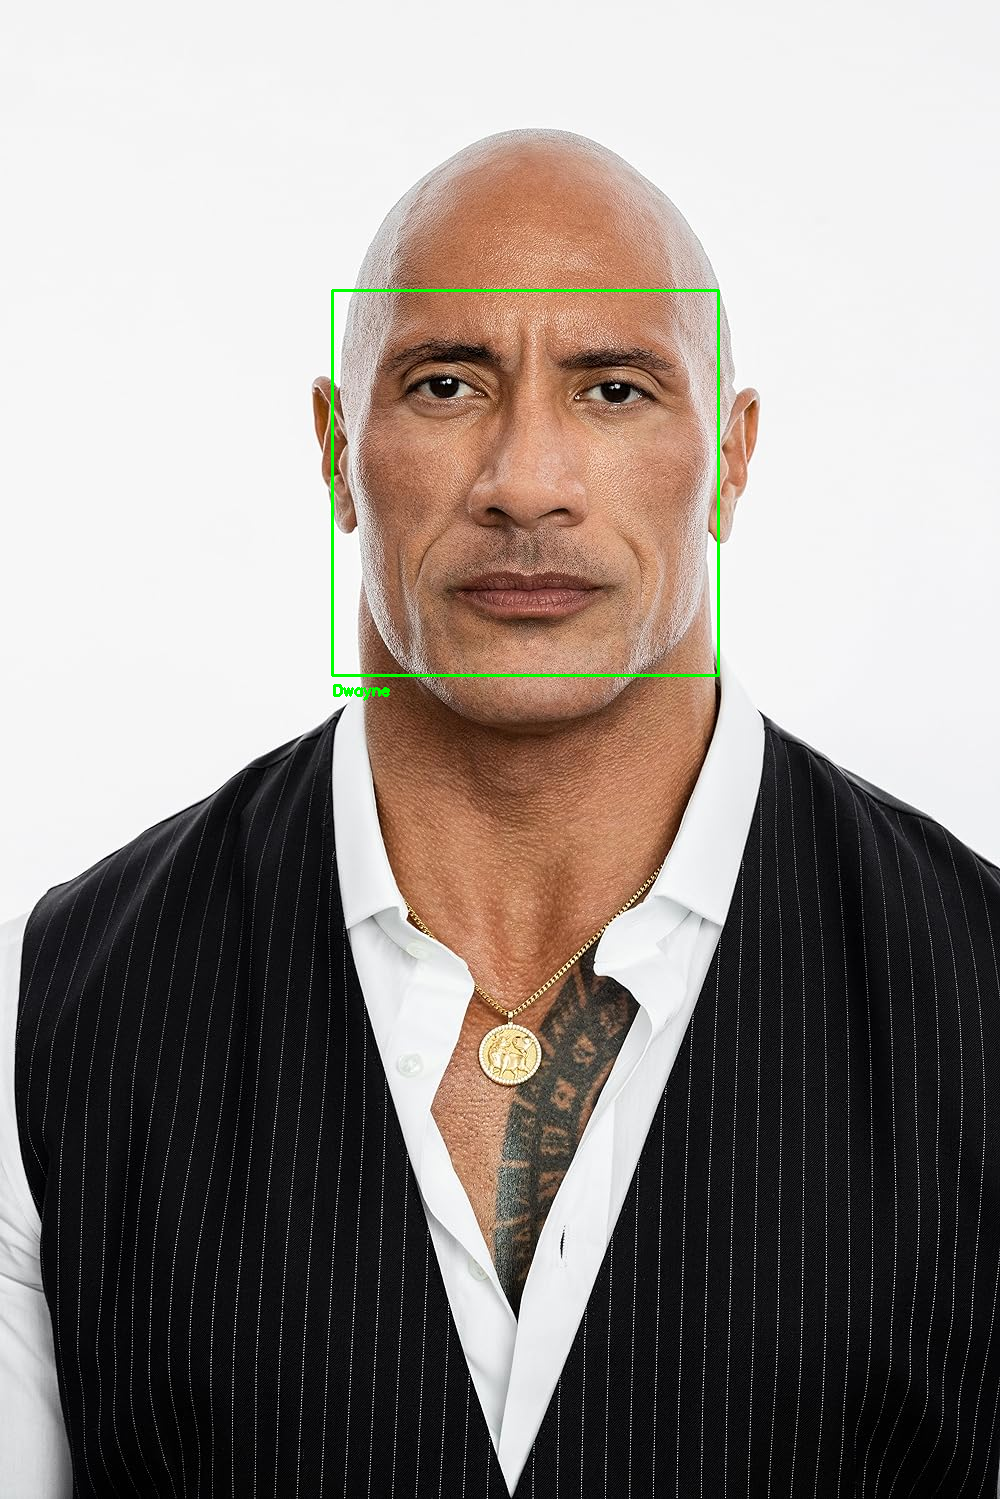

[Errno 21] Is a directory: '/content/drive/MyDrive/unlabeled_library_images/.ipynb_checkpoints'
cannot identify image file '/content/drive/MyDrive/unlabeled_library_images/faces_data.csv'
cannot identify image file '/content/drive/MyDrive/unlabeled_library_images/image_face_names.csv'
cannot identify image file '/content/drive/MyDrive/unlabeled_library_images/new_data.csv'
cannot identify image file '/content/drive/MyDrive/unlabeled_library_images/test.csv'


In [664]:
print_labelled_images()